# SAS DLPy Image Classification Examples: Dolphin vs. Giraffe


This notebook is a collection of sequential examples that perform image classification tasks using the SAS DLPy API. The examples use different versions and sources of CNN models. The [Model1](#Model1) example manually creates a simple CNN architecture. The [Model2](#Model2), [Model3](#Model3), and [Model4](#Model4) examples import different CNN architectures (for instance, ResNet50) along with their pre-trained weights. Unlike Model2, Model3, and Model4, [Model5](#Model5) loads a CNN architecture from a stored SAS .sashdat table.  

All of the examples use a small toy data set that contains dolphin or giraffe images for the classification tasks. You can download the example image data at 
https://github.com/sassoftware/python-dlpy/tree/master/dlpy/tests/datasources/giraffe_dolphin_small. 

When downloading the data to your computing environment, the folders for the giraffe and dolphin images in the example should be structured as follows:

 * Giraffe_Dolphin
       * Giraffe
           * Giraffe image 1
           * Girrafe image 2
           * ...
       * Dolphin
           * Dolphin image 1
           * Dolphin image 2
           * ...       

All of the examples in this notebook require a configured SAS computing environment. This includes SAS CAS (Cloud Analytic Services) server sessions with SAS swat, as well as Python requirements. Example tasks include loading required DLPy functions and a plotting library. In addition, open-source Python utilities such as pandas, matplotlib, scikit-learn, and SAS Pipefitter. 

*Note:* This Jupyter notebook begins with computing environment configuration instructions. The code and models that follow are intended for use with a SAS CAS server operating in SMP mode. Performing the examples in this collection using a CAS server operating in MPP mode is not recommended; some of the larger network examples might cause floating point errors in an MPP environment.

The rest of the notebook consists of five sequential SAS DLPy image classification model examples. All of the examples include data that you can download, or data that the example generates. You should be able to run this notebook in your own SAS CAS environment. 

This notebook contains multiple examples and is organized as follows:

* Set Up SAS Computing Environment for DLPy Examples

* The [Model1](#Model1) example is a simple CNN model designed to classify the input images as either a dolphin or giraffe. This example includes a heatmap analysis to visualize what is important in an image according to the trained model. The example also include feature map generation, and how to save models to ASTORE.

* The [Model2](#Model2) uses DLPy to import a pre-trained ResNet50 image classification model where the model weights are stored in a .h5 file. This example includes visualization of classification predictions.

* The [Model3](#Model3) example uses DLPy to import a pre-trained VGG16 image classification model where the weights are stored in a .h5 file. This example includes a code snippet that shows how to use image features to fit a decision tree using SAS Pipefitter, as well as code that shows how to fit a PCA analysis using scikit-learn.

* The [Model4](#Model4) example uses DLPy to import a pre-trained image classification ResNet50 model and perform transfer learning. The ResNet50 model uses weights are stored in a .h5 file. The Model4 example also includes heatmap analysis.

* The [Model5](#Model5) example uses DLPy to load a pre-trained VGG16 model that was saved in a SAS table to perform image classification.

<h2 id="Setup">Set Up the SAS Computing Environment for DLPy Examples <a name="Setup" /><a class="anchor-link" href="#Setup"></a></h2> 



All of the examples in this collection assume that SAS DLPy is recognized by your Python environment, either through *PYTHONPATH* or installing it via pip/conda with an available CAS Server. This sections the following tasks to configure your computing environment:

* Load Required Python Libraries
* Import SAS Scripted Wrapper for Analytics Transfer 
* Start SAS CAS Session
* Ensure that SAS DLPy is in your System Path PYTHONPATH
* Load Required DLPy Libraries


**Load Python Library** 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import swat

**Start a CAS Session**

SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [2]:
host_name='your-qualified.server-name.com'

# port_number='12345' # use a unique 5-digit port ID
port_number=12345

sess = swat.CAS('your-qualified.server-name.com', 12345)

## Load Images for DLPy Examples

After establishing an active SAS CAS session and importing the SWAT and DLPy modules, load the Dolphin vs. Giraffe images. The collection of DLPy examples all use the same image collection.

In [3]:
from dlpy.images import ImageTable

**Folder Structure for Dolphin vs. Giraffe Images**

The folder structure for the giraffe and dolphin images in the example is as follows:

   * Giraffe_Dolphin
       * Giraffe
           * Giraffe image 1
           * Girrafe image 2
           * ...
       * Dolphin
           * Dolphin image 1
           * Dolphin image 2
           * ...       
           
In the following code, the value for `img_path` represents a fully-qualified directory path to the images. The path must be accessible by the CAS server session.  

In [4]:
img_path='/your/server/path-to/image-directory/giraffe_dolphin_small'

my_images = ImageTable.load_files(sess, path=img_path)

The image table `my_images` now contains the images in the specified `path`.

**Verify Images in `my_images` Data Table**

Now we can verify that the `my_images` data table populated. Use the `head()` function to examine the first few rows. 

In [5]:
my_images.head()

Selected Rows from Table IMAGEDATA_VNKPG2

                                             _image_  _label_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   

         _filename_0  _id_  
0  giraffe_10959.jpg    31  
1  giraffe_10035.jpg    13  
2  giraffe_10187.jpg    25  
3  giraffe_10183.jpg    29  
4  giraffe_10974.jpg    23

Now, check some of the images in the data table. Display a table of 4 randomly selected training images from the image table `my_images`. 

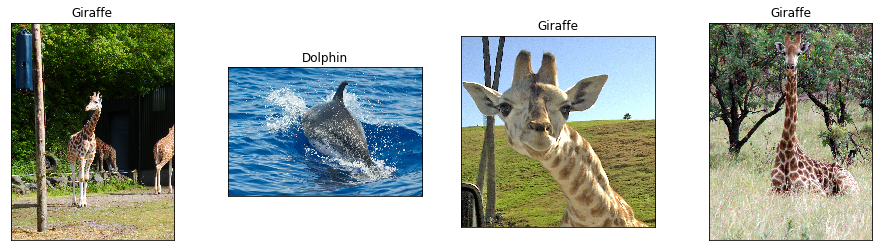

In [6]:
my_images.show(nimages=4, ncol=4, randomize=True)

What is the proportion of dolphin and giraffe images within the image table? Show a frequency analysis of the image table by label values: 

In [7]:
my_images.label_freq

Frequency for IMAGEDATA_VNKPG2

         Level  Frequency
Dolphin      1         49
Giraffe      2         45

Now run an image summary to display image metadata from the table:

In [8]:
my_images.image_summary

jpg                    94
minWidth              400
maxWidth             1024
minHeight             258
maxHeight            1024
meanWidth         904.723
meanHeight        795.436
mean1stChannel    128.505
min1stChannel           0
max1stChannel         255
mean2ndChannel    124.579
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    97.7212
min3rdChannel           0
max3rdChannel         255
dtype: object

## Process Images for DLPy Examples

All of the DLPy examples in this collection use the Dolphin vs. Giraffe images to perform image classification tasks. Image data could be processed prior to model training. Image processing can include partitioning image data, standardizing image size parameters, and augmenting the image data to upsample the images in the training data. 

**Resize Input Image Dimensions**

The image processing task prepares the data for model training. The input images may not all be the same size. Deep learning models usually requires a fixed input size. The following Python code resizes all images to 224x224 pixels. As `height` is not explicitly provided, `height` is also resized to 224 and then, checks the resized images by displaying 4 of the images.

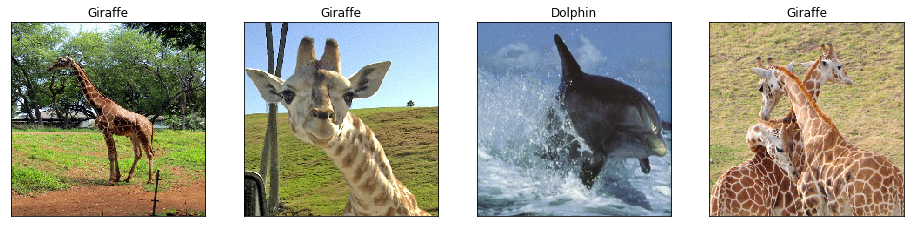

In [9]:
my_images.resize(width=224)
my_images.show(4, 4)

**Split Image Data into Training and Testing Partitions**



The code that follows partitions the data in the image table into two groups: a training image group and a testing image group. 80% of the data is allocated for training images `tr_img`, and the remaining 20% of the data is allocated for testing images `te_img`. The code uses a random seed value of `123` when selecting observations for partitioning.

In [10]:
## Splitting the Data into Training and Testing Partitions
from dlpy.splitting import two_way_split

In [11]:
tr_img, te_img = two_way_split(my_images, test_rate=20, seed=123)

**View Distibution of Dolphin and Giraffe Images in the Train and Test Data**

Now there are distinct train `tr_img` and test `te_img` images. Perform a label frequency analysis to show how the giraffe and dolphin images are distributedin the train and test data tables.

In [12]:
tr_img.label_freq

Frequency for TRAIN_DNCK5X

         Level  Frequency
Dolphin      1         39
Giraffe      2         36

In [13]:
te_img.label_freq

Frequency for TEST_WNFB2C

         Level  Frequency
Dolphin      1         10
Giraffe      2          9

**Augment the Training Data**

Data augmentation has become a standard precodure in image classification tasks. There are a number of different ways to apply data augmentation such as cropping, rotating, and flipping. In this case, we use cropping. 

The code below builds patches with size 200 x 200 pixels and then resizes them to 224 x 224 pixels. It does a sliding window approach with a step size of 24 pixels.

In [14]:
tr_img.as_patches(width=200, height=200, step_size=24, output_width=224, output_height=224)

Now display a frequency table of the augmented training data:

In [15]:
tr_img.label_freq

Frequency for TRAIN_DNCK5X

         Level  Frequency
Dolphin      1        156
Giraffe      2        144

After augmenting the data with cropping, the number of dolphin images in the data has increased from approximately 40 (39) to over 150 (156). The number of giraffe images in the training data has increased from approximately 35 (36) to over 140 (144). (*Note:* Your augmented image frequency results might vary slightly (+/- 1) from the displayed output.)

Now use a table with 4 columns to display images from the augmented training data set. Note that all of the images in the augmented training data are 224 x 224 pixels.

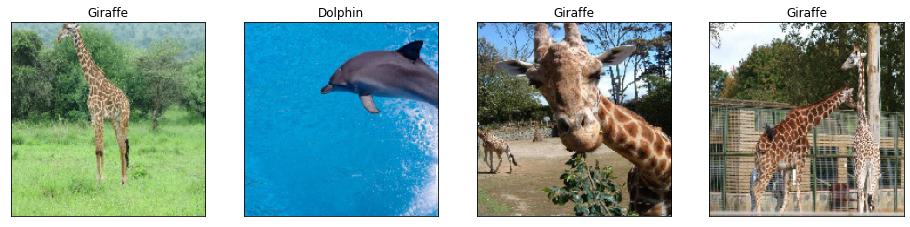

In [16]:
tr_img.show(4,4)

<h2 id="Model1">Model1: Simple CNN <a name="Model1" /><a class="anchor-link" href="#Model1"></a></h2>

### Build a simple CNN model

Here we will use SAS DLPy functions to define a simple CNN model. The code below imports DLPy libraries that are required to specify a sequential CNN model layer-by-layer: 

In [17]:
from dlpy import Sequential
from dlpy.model import *
from dlpy.layers import * 
from dlpy.applications import *

The code below creates a sequential CNN model named `model1` that uses CAS table `Simple_CNN`.

In [18]:
model1 = Sequential(sess, model_table='Simple_CNN')

The `model1` model is created and named. Now define the model architecture in DLPy. Begin by defining an input layer for a convolutional network with color images (3 channels) and images sized 224 pixels high by 224 pixels wide. The model will do a global constrast normlization using the mean values for each channel as the corresponding offset values for those channels. The mean pixel intensity values for each channel in the training data is found in a function `tr_img.channel_means`. 

**Add Input Layer**

In [19]:
model1.add(InputLayer(3, 224, 224, offsets=tr_img.channel_means))

NOTE: Input layer added.


The input layer in this CNN model is followed by a pair of layers: a 2-D convolution layer and a pooling layer. The convolution layer should have 8 filters and a kernel size of 7 x 7. The pooling layer should have a size of 2 by 2.

**Add 2-D Convolution Layer and Pooling Layer**

In [20]:
model1.add(Conv2d(8, 7))
model1.add(Pooling(2))

NOTE: Convolution layer added.
NOTE: Pooling layer added.


Continue to define the CNN architecture by inserting an additional pair of 2-D convolution and pooling layers. The second set of 2-D convolution and pooling layers uses the same parameter values as the first set of 2-D convolution and pooling layers: 8 filters and a kernel size of 7 x 7 for convolution, and a pooling layer with a size of 2 by 2.

**Add Another 2-D Convolution Layer and Pooling Layer**

In [21]:
model1.add(Conv2d(8, 7))
model1.add(Pooling(2))

NOTE: Convolution layer added.
NOTE: Pooling layer added.


**Add Fully Connected (Dense) layer**

Further define the CNN architecture by following the last pooling layer with a fully connected (dense) layer. The fully connected layer contains 16 neurons.

In [22]:
model1.add(Dense(16))

NOTE: Fully-connected layer added.


**Add Output layer**

Complete the CNN model architecture by specifying the output layer. The output layer uses the Softmax activation function and has 2 neurons (matching the number of classes in the training data).

In [23]:
model1.add(OutputLayer(act='softmax', n=2))

NOTE: Output layer added.
NOTE: Model compiled successfully.


After creating and naming the CNN model, defining the model architecture, and successfully compiling the model in DLPy, display a tabular summary of the compiled model.

In [24]:
model1.print_summary()

Layer Id    Layer    Type  Kernel Size  Stride Activation    Output Size  \
0        0   Input1   input                            None  (224, 224, 3)   
1        1  Convo.1   convo       (7, 7)  (1, 1)       Relu  (224, 224, 8)   
2        2    Pool1    pool       (2, 2)  (2, 2)        Max  (112, 112, 8)   
3        3  Convo.2   convo       (7, 7)  (1, 1)       Relu  (112, 112, 8)   
4        4    Pool2    pool       (2, 2)  (2, 2)        Max    (56, 56, 8)   
5        5    F.C.1      fc  (25088, 16)               Relu             16   
6        6  Output1  output      (16, 2)            Softmax              2   
7                                                                            

  Number of Parameters  
0               (0, 0)  
1            (1176, 8)  
2               (0, 0)  
3            (3136, 8)  
4               (0, 0)  
5          (401408, 0)  
6              (32, 2)  
7               405770

Optional: Un-comment the code in the following cell to display a Graphviz plot of the 'model1' architecture.

In [25]:
# Optional Network Architecture Plot
# model1.plot_network()

### Model1: Train Network Using Augmented Data

The following code trains the CNN model using the augmented training data, a mini-batch size of 2, a maximum of 5 epochs, and a learning rate of 0.0001, using 1 GPU (GPU1). 

<b>Note:</b> The total number of mini-batches used in the optimization is computed as (mini-batch size * number of threads * number of workers). 


In [26]:
model1.fit(data=tr_img, 
           mini_batch_size=2,
           n_threads=1,
           max_epochs=5, 
           lr=1E-4, 
           gpu=Gpu(devices=[1]), 
           log_level=2
          )

NOTE: Inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 405786.
NOTE:  The approximate memory cost is 128.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.27 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 2.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 2.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001           0.326    0.04333     0.68
NOTE:  1        0.0001         0.05176       

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                    simple_cnn
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                             7
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             1
 5              Number of Convolutional Layers                             2
 6                    Number of Pooling Layers                             2
 7            Number of Fully Connected Layers                             1
 8                 Number of Weight Parameters                        405752
 9                   Number of Bias Parameters                            34
 10           Total Number of Model Parameters                        405786
 11  Approximate Memory Cost for Training (MB)                           129

[OptIterHistory]

    Epoch  LearningRate      Loss  FitError
 0      1        0.0001  0.325977  0.043333
 1      2        0.0001  0.051762  0.010000
 2      3        0.0001  0.036401  0.013333
 3      4        0.0001  0.002897  0.000000
 4      5        0.0001  0.000578  0.000000

[OutputCasTables]

             casLib                Name    Rows  Columns  \
 0  CASUSER(chrobi)  Simple_CNN_weights  405786        3   
 
                                             casTable  
 0  CASTable('Simple_CNN_weights', caslib='CASUSER...  

+ Elapsed: 6.93s, user: 4.91s, sys: 1.61s, mem: 141mb

### Summarize the training history

It is useful to visualize model training parameters across epochs. You can print a table of summary as follows:

In [27]:
model1.training_history

Epoch  LearningRate      Loss  FitError
0      1        0.0001  0.325977  0.043333
1      2        0.0001  0.051762  0.010000
2      3        0.0001  0.036401  0.013333
3      4        0.0001  0.002897  0.000000
4      5        0.0001  0.000578  0.000000

Alternatively, you can visualize the training history in a plot as follows:

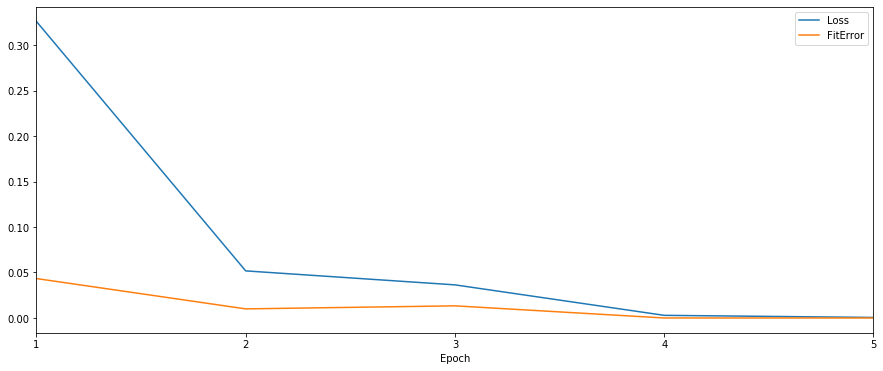

In [28]:
model1.plot_training_history(fig_size=(15, 6))

### Model1: Score Input Images

Now use the trained model to score input images. Use the test data `te_img` that was partitioned earlier in the example.  

In [29]:
model1.evaluate(te_img)

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            19
 1  Number of Observations Used            19
 2  Misclassification Error (%)             0
 3                   Loss Error      4.266E-7

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(chrobi)  Valid_Res_pE97Bn    19        9   
 
                                             casTable  
 0  CASTable('Valid_Res_pE97Bn', caslib='CASUSER(c...  

+ Elapsed: 0.197s, user: 0.846s, sys: 0.695s, mem: 1.98e+03mb

In the example training environment, `model1` trained well. The output shows an image misclassification rate of 0%. When you train the model in your environment, you might not get the exact same statistics, but they should be similar (0-6%). 

You can further visualize the performance of the classification model `model1` by creating a confusion matrix. A confusion matrix compares the predicted classes of true positives, false negatives, false positives, and true negatives. In this example, the matrix is a two-row cross-tabulation chart for Dolphin and Giraffe. Column 1 values reflect the number of correctly predicted Dolphin images, and column 2 values reflect the number of correctly predicted Giraffe images. The code is as follows:

In [30]:
model1.valid_conf_mat

[Crosstab]

    _label_  Col1  Col2
 0  Dolphin  10.0   0.0
 1  Giraffe   0.0   9.0

+ Elapsed: 0.00624s, user: 0.0051s, sys: 0.00948s, mem: 2.45mb

With a misclassification rate of 5%, the confusion chart data shows 19 correct classifications and no misclassifications. (Note: in other training environments with the toy data set, there might be small variances (+/- 1) in the number of correct classifications and misclassifications.)

The image classification results can also be plotted for a different visualization. The following code displays a plot with 2 random images that were correctly classified (actual class=predicted class), along with a predicted probability bar chart for each image.


NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(chrobi).


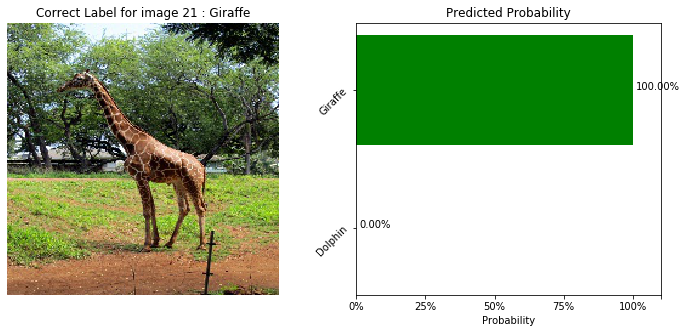

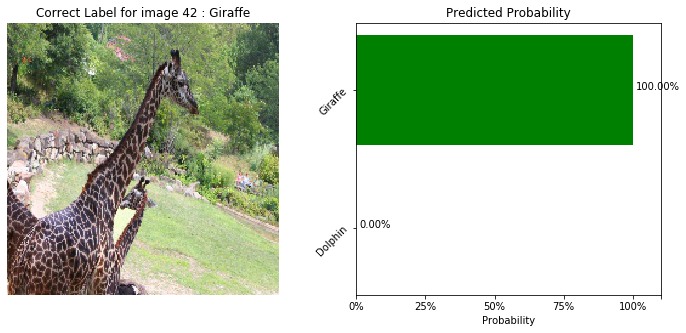

In [31]:
model1.plot_evaluate_res(img_type='C', randomize=True, n_images=2)

### Model1: Perform Heatmap Analysis

Heat maps are visualization tools that use color to indicate different values of interest. In this case, the most important regions of an image are the regions that provide the most useful information to the model, enabling it to determine a distinction of the actual class. In other words, heat maps visualize which parts of an image are most useful to the model when predicting the class.  

The following code to generate heat maps uses the score results from the CNN network model1. The analysis focuses on a 56 x 56 pixel mask over the image using a step size of 8 pixels. The 'max display' setting in the code limits the heat map output to two rows, where each row displays the heat map information for a random image. 

Using results from model.predict()
NOTE: The number of images in the table is too large, only 3 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_029S5P contains compressed images.


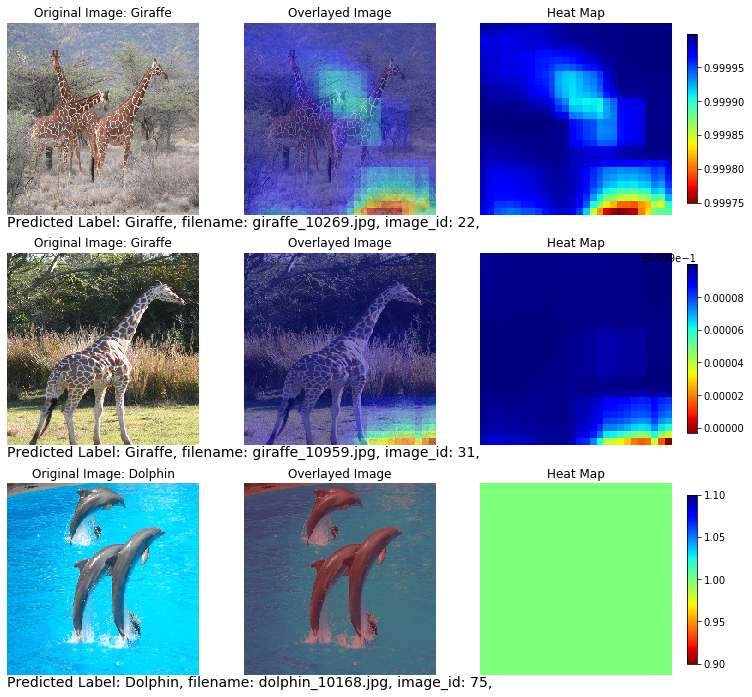

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_029S5p from caslib CASUSER(chrobi).


_id_        _filename_0                                            _image_  \
0   22  giraffe_10269.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1   31  giraffe_10959.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2   75  dolphin_10168.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

   _label_ I__label_                                           heat_map  \
0  Giraffe   Giraffe  [[0.9999916553497314, 0.9999916553497314, 0.99...   
1  Giraffe   Giraffe  [[0.9999978542327881, 0.9999978542327881, 0.99...   
2  Dolphin   Dolphin  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

   P__label_Dolphin  P__label_Giraffe  
0      2.919059e-06          0.999997  
1      2.881908e-07          1.000000  
2      1.000000e+00          0.000000

In [32]:
model1.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, max_display=3)

###  Model1: View Feature Maps

Feature maps display the output activations for a given filter.
The following code uses the test data from the Model1 example to generate and display feature map data. First, create the feature map data. This example uses the test data and filters for images labeled `Dolphin`. The `idx=0` setting indicates that the row 0 index data should be used to construct the feature maps.

In [33]:
model1.get_feature_maps(data=te_img, label='Dolphin', idx=0)

Now display the feature map data for different layers in the network architecture. The following code displays feature maps for layer 0, or the input layer of Model1.


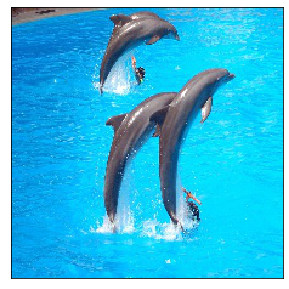

In [34]:
model1.feature_maps.display(layer_id=0)

Next, submit code to display the feature, or activation maps for the second layer in model1. In our model this layer is a 2-D convolution layer with 8 filters. The output should display a feature map for each filter.


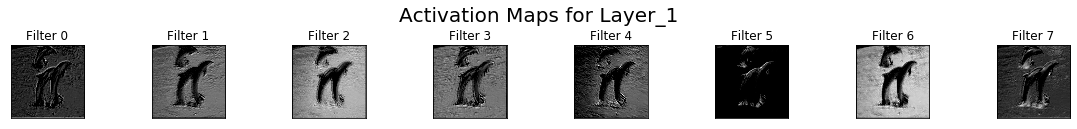

In [35]:
model1.feature_maps.display(layer_id=1)

The next line of code displays the feature map for the third layer in model1. The third layer is a pooling layer that has 8 filters. The output will also include 8 activation maps.

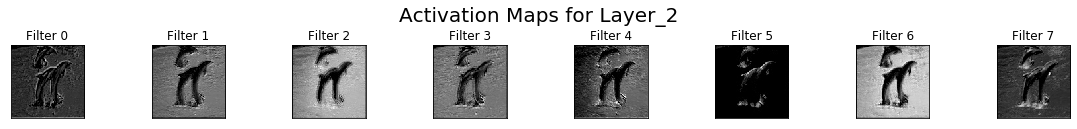

In [36]:
model1.feature_maps.display(layer_id=2)

The next line of code displays the activation maps for the fifth layer of the model1 network. The fifth layer of model1 is a pooling layer that has 8 filters. The code and output is as follows: 

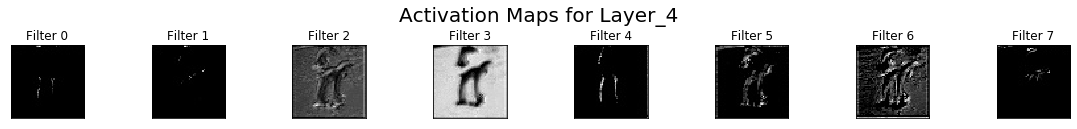

In [37]:
model1.feature_maps.display(layer_id=4)

### Model1: Save to ASTORE

Now save the Model1 CNN model using the ASTORE format. The ASTORE format allows you to deploy your saved model in another environment. When `astore` is specified, the model is saved to specified directory.

The following code will save the ASTORE version of 'model1' to the specified path.

In [38]:
model1.deploy(path='/server-path/to-deployment/directory/', output_format='astore')

NOTE: Model astore file saved successfully.


It is useful to save models in the `.sashdat` (SAS Hadoop Data Table) format in order to faciliate reloading the models for later access. For example, you might want to retrain the model later with updated data, or use the model for transfer learning.  

To save in `.sashdat` format, specify the output_format `table` option in the `deploy()` syntax. The `.sashdat` model is saved to the specified directory in the following code.

In [39]:
model1.deploy(path='/server-path/to-deployment/directory/', output_format='table')

NOTE: Model table saved successfully.


<h2 id="Model2">Model2: Perform ImageNet Analysis Using an Imported Caffe ResNet50 Model <a name="Model2" /><a class="anchor-link" href="#Model2"></a></h2>

DLPy can import pre-defined models along with pre-trained weights from other libraries such as Keras and Caffe. This example performs an ImageNet analysis using a Caffe ResNet50 model with a pre-trained `.h5` weight file. This example DLPy model is saved as 'model2'.

This example requires access to a ResNet50 Caffe library model, including the associated `.h5` file that contains the associated trained model weights. You can obtain the ResNet50 files in a zip format from the SAS Deep Learning Models and Tools support page [here](http://support.sas.com/documentation/prod-p/vdmml/zip/resnet50.zip).

You should unpack and save the files from resnet50.zip to a directory location that the server can see. This example saves the files to an example server path. Your path will be different.

In [40]:
from dlpy.applications import ResNet50_Caffe, VGG16

The Python code snippet that follows is used to create a pre-defined ResNet50 model, including model weights determined by training on the ImageNet 1K dataset. The following is information about the pre-defined ResNet50 model:

* The model uses pre-trained weights.
* The-trained weights are stored on the server at '/u/username/ResNet50_Caffe/'.
* The name of the pre-trained weights file in the defined path is 'ResNet-50-model.caffemodel.h5'.
* The model table in the example is named 'RESNET50_CAFFE'.
* This model architecture does not use a batch normalization layer before the convolutional layer in the residual block. 
* The model training data contains 1000 object classes.
* The model data images are BGR color images, so n_channels=3
* Images are uniformly sized to dimensions of 224 pixels high by 224 pixels wide.
* Do not perform data augmentation by flipping or cropping existing images.
* The model training data uses default BGR offset values of (B) 103.939, (G) 116.779, and (R) 123.68.
* The model uses pretrained weights as defined in the ResNet-50-model.caffemodel.h5 file.
* The fully trained weights are used in the top (fully connected) layers.

In [42]:
# PRE_TRAIN_WEIGHT_LOC is the fully-qualified directory that contains your model weights.

PRE_TRAIN_WEIGHT_LOC = '/server-path/to-saved-model/weight-files/'
pre_train_weight_file = os.path.join(PRE_TRAIN_WEIGHT_LOC, 'ResNet-50-model.caffemodel.h5')

model2 = ResNet50_Caffe(sess,
                        model_table='RESNET50_CAFFE', batch_norm_first=False,
                        n_classes=1000, n_channels=3, width=224, height=224, scale=1,
                        random_flip='none', random_crop='none',
                        offsets=(103.939, 116.779, 123.68),
                        pre_trained_weights=True, 
                        pre_trained_weights_file=pre_train_weight_file,
                        include_top=True)

NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50_caffe" according to the model name in the table.
NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_QFBDBZ in caslib CASUSER(chrobi).
NOTE: The table NEW_LABEL_TABLE_QFBDBZ has been created in caslib CASUSER(chrobi) from binary data uploaded to Cloud Analytic Services.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!


Use the `print_summary()` function to browse a summary of the newly imported `model2` parameters and architecture:

In [43]:
model2.print_summary()

Layer Id           Layer       Type   Kernel Size      Stride Activation  \
0          0            data      input                                 None   
1          1           conv1      convo        (7, 7)  (2.0, 2.0)   Identity   
2          2        bn_conv1  batchnorm                            Rectifier   
3          3           pool1       pool        (3, 3)  (2.0, 2.0)        Max   
4          4  res2a_branch2a      convo        (1, 1)  (1.0, 1.0)   Identity   
..       ...             ...        ...           ...         ...        ...   
122      122   bn5c_branch2c  batchnorm                             Identity   
123      123           res5c   residual                            Rectifier   
124      124           pool5       pool        (7, 7)  (7.0, 7.0)       Mean   
125      125          fc1000     output  (2048, 1000)                Softmax   
126                                                                            

        Output Size Number of Parameters  
0     (224, 224, 3)               (0, 0)  
1    (112, 112, 64)           (9408, 64)  
2    (112, 112, 64)             (0, 128)  
3      (56, 56, 64)               (0, 0)  
4      (56, 56, 64)            (4096, 0)  
..              ...                  ...  
122    (7, 7, 2048)            (0, 4096)  
123    (7, 7, 2048)               (0, 0)  
124    (1, 1, 2048)               (0, 0)  
125            1000      (2048000, 1000)  
126                             25557096  

[127 rows x 8 columns]

**Note:** This is a large and deep network with around 25 million parameters!!!

Normally it is a good idea to visualize models. However, this ResNet50 model is large and deep, and visualizations would be processor-burdened and messy. This example skips the model visualization task. 


### Model2: Evaluate Pretrained Network Using Dolphin and Giraffe Images

ImageNet is an image database organized according to the WordNet hierarchy. Established Caffe libraries contain data for the ImageNet ILSVRC2012 classes, including semantic image labels. There are 1,000 image classes in the ILSVRC2012 classes, and each class has its own image label. They are referred to as the ImageNet 1k labels.  

Now use `model2` to score the `my_images` data, using the ImageNet1K label set. Execute using only one GPU.

The next step uses the `plot_evaluate_res()` function to create bar charts of the classification predictions. In the charts, top 5 predictions are visualized along with their probabilities.

By default, the function generates plots for `n_images=3`. Setting `img_type=A` means that all classifications (correct or incorrect) are eligible for plotting. 


NOTE: Due to data distribution, miniBatchSize has been limited to 2.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(chrobi).


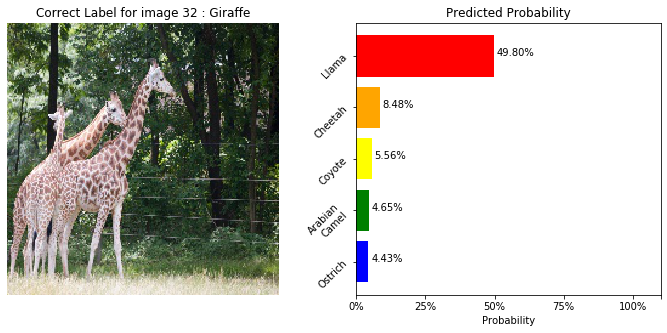

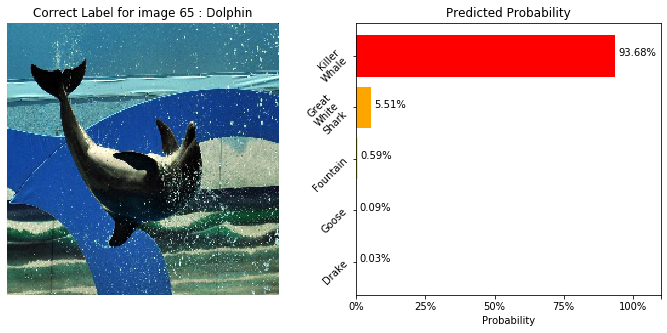

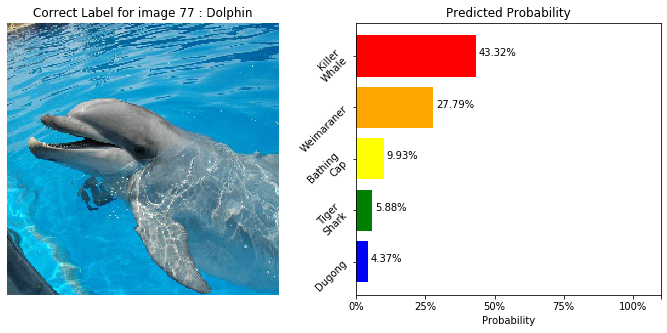

In [44]:
model2.predict(data=my_images, gpu=Gpu(devices=[1]))
model2.plot_evaluate_res(img_type='A', n_images=3, randomize=True)

The scored data does not have exact matches. There is a good reason for this: the ImageNet1K data includes 1,000 labeled classes, but there is no labeled class for dolphin or giraffe. Therefore none of the ImageNet1K classes could be a true prediction.

What happens when the label data for a scoring model does not include a true class for the object in an image? In these cases, the model tends to predict the most semantically similar classification. 



<h2 id="Model3">Model3: Using Feature Maps for Decision Trees and Principal Component Analysis (PCA) <a name="Model3" /><a class="anchor-link" href="#Model3"></a></h2>


Interim results from a deep neural architecture can also be used with different machine learning algorithms. 

In classic image analytics, images are represented by feature descriptors. In other words, pixels are quantified into a collection of features that represent an image. These feature descriptors can then be used in machine learning algorithms,  such as SVM or decision trees. 

In the Model3 example, images are represented as feature maps that are calculated using a pre-defined VGG16 model with pre-trained weights, that was trained on the ImageNet1K dataset.

### Model3: Use DLPy to Import Caffe VGG16 Model and Pre-Trained Model Weights File

This example requires access to a VGG16_Caffe library model, including the associated `.h5` file that contains the trained model weights. 

You can download the open-source Caffe VGG-16 network and model parameter files from the SAS Support site here: http://support.sas.com/documentation/prod-p/vdmml/zip/vgg16.zip . You should unzip the files to a directory that your server can access.

The following example code specifies a fully-qualified path to the `.h5` file that contains the pre-trained weights for the VGG16 network. Your path will be different--it should reference the location where you unzipped the VGG-16 parameter files. 

Next, the code defines the following VGG16 parameter settings for the model 'model3':

* Use pre-trained weights as defined in the specified .h5 file.
* The example pre-trained weights are stored in a fictional server directory named '/disk/linux/VGG16'. Replace the example's path with the sever location where you unzipped the example VGG-16 files. 
* The name of the pre-trained weights file in the defined path is 'VGG_ILSVRC_16_layers.caffemodel.h5'.
* Name the model table 'VGG16'.
* The input data features 1000 object classes.
* The input data uses BGR color images, therefore n_channels=3.
* The input data image dimensions are 224 px high by 224 px wide.
* Do not flip or crop existing random images to augment the input data.
* Use default BGR input channel offsets of 103.939, 116.779, 123.68.
* Include fully trained weights in the top (fully connected) layers.

In [45]:
# PRE_TRAIN_WEIGHT_LOC points to the name of the fully-qualified directory that contains your model weights.

PRE_TRAIN_WEIGHT_LOC = '/server-path/to-saved-model/weight-files/'
pre_train_weight_file = os.path.join(PRE_TRAIN_WEIGHT_LOC, 'VGG_ILSVRC_16_layers.caffemodel.h5')

model3 = VGG16(sess, model_table='VGG16', 
               n_classes=1000, n_channels=3, width=224, height=224, scale=1,
               random_flip='none', random_crop='none',
               offsets=(103.939, 116.779, 123.68),
               pre_trained_weights=True,
               pre_trained_weights_file=pre_train_weight_file,
               include_top=True)

NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16" according to the model name in the table.
NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_NOR0HM in caslib CASUSER(chrobi).
NOTE: The table NEW_LABEL_TABLE_NOR0HM has been created in caslib CASUSER(chrobi) from binary data uploaded to Cloud Analytic Services.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!


### Model3: Save Imported Model as .sashdat Table for Later Deployment

After the model VGG16 is successfully imported, save the imported trained and weighted model as a .sashdat file for later use the following notebook example for Model5.

<b>NOTE:</b> The combined sizes of the model and weight .sashdat files for this network are approximately 3.25 GB. Please specify an location on your network that has enough storage to perform this step.


In [46]:
# Deploy the pre-trained model as a .sashdat file.
# The deployed file is not used with Model3, but it will 
# be used to build Model5 later in this notebook.

model3.deploy(path='/path-to/server-accessible/deployment-directory/', output_format='table')


NOTE: Model table saved successfully.


### Model3: Use ImageNet VGG16 Network to Extract Feature Maps

Feature extraction is a valuable technique for image processing. SAS DLPy supports the `get_features()` function that extracts features for a data table from a specified layer.

The code below extracts features from the test image data, using the `pool5` layer of VGG16 `model3`. 

In [47]:
X, y = model3.get_features(data=te_img, dense_layer='pool5')

In [48]:
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['Giraffe', 'Dolphin', 'Giraffe', 'Giraffe', 'Dolphin', 'Dolphin',
        'Dolphin', 'Giraffe', 'Giraffe', 'Giraffe', 'Giraffe', 'Giraffe',
        'Dolphin', 'Dolphin', 'Dolphin', 'Giraffe', 'Dolphin', 'Dolphin',
        'Dolphin'], dtype=object))

The `get_features()` function returns two arrays in the output above. The first array is an n-dimensional array, where n is the sample size and p is the number of features extracted by the model at the specified `dense_layer`. The second array is is of size n and contains the response variable of the original data.

### Model3: Use the SAS Pipefitter Utility to Fit a Decision Tree

Decision trees are powerful algorithms that are capable of fitting complex data sets used in image analysis. SAS DLPy supports the SAS Pipefitter API.  Pipefitter is a Python API designed to develop machine learning pipelines. The pipelines have stages that can perform various tasks: fit parameter estimates using machine learning techniques (such as decision trees), use hyperparameter tuning to speed model selection, score data, assess models, perform variable transformation, parameter estimations, and hyperparameter tuning. 

To complete this segment of the example, you must install Pipefitter in your Python environment: the example code call Pipefitter modules. For detailed SAS Pipefitter API installation and usage instructions, see https://github.com/sassoftware/python-pipefitter. 

The example begins by importing Pandas because the model uses dataFrame structures. Next, the example imports the `HyperParameterTuning` class from the Pipefitter model selector. The `HyperParameterTuning` class tests a grid of model parameters and applies them to an estimator or a pipeline, then returns the compiled results of various model parameter permutations. 

Finally, the example code imports `DecisionTree`, `DecisionForest`, and `GBTree` classes from the Pipefitter estimator. When you add an estimator to a pipeline, the `fit()` method performs parameter estimations and then generates a model. The pipeline returns a PipelineModel object that includes the model.

In [49]:
import pandas as pd

from pipefitter.model_selection import HyperParameterTuning
from pipefitter.estimator import DecisionTree, DecisionForest, GBTree

The following code sets set target and input parameter values, defines depth limits for the decision tree to be created, sets up and loads the DataFrame, then fits a decision tree model. After the decision tree is created, it is used to score the image data.


In [50]:
params = dict(target='label', 
              inputs=[str(i) for i in range(16)])
dtree = DecisionTree(max_depth=6, **params)
data = pd.DataFrame(X)
data['label'] = y
data.columns = ['%s' % x for x in data.columns]
casdata = sess.upload_frame(data)
model = dtree.fit(casdata)
score = model.score(casdata)
score

NOTE: Cloud Analytic Services made the uploaded file available as table TMPZDYFNQR1 in caslib CASUSER(chrobi).
NOTE: The table TMPZDYFNQR1 has been created in caslib CASUSER(chrobi) from binary data uploaded to Cloud Analytic Services.


Target                     label
Level                      CLASS
Var                       _DT_P_
NBins                        100
NObsUsed                      19
TargetCount                   19
TargetMiss                     0
PredCount                     19
PredMiss                       0
Event                    Dolphin
EventCount                    10
NonEventCount                  9
EventMiss                      0
AreaUnderROCCurve            0.5
KS                             0
KSCutOff                       0
MisClassificationRate    47.3684
CRCut                          0
ClassificationCutOff         0.5
dtype: object

The output shows that the resulting decision tree model scored the image data for the target event 'Dolphin'. 

###  Model3: Fit a Principal Component Analysis (PCA) Model using Scikit-learn


Principal component analysis (PCA) uses Singular Value Decomposition (SVD) to reduce the linear dimensionality of input data and projects it to a lower dimensional space. In the open-source scikit-learn package, PCA is implemented as a transformer object that learns n components in its fit method, and can be used on new data to project it on these components.

The following code requires that you have modules for matplotlib (see http://matplotlib.org) and sci-kit learn sklearn (see http://scikit-learn.org). If your Python environment does not have matplotlib and sklearn modules, use the links above to install them before running the example code.

In [51]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

The following code generates principal component data for the dolphin and giraffe images. Next, the code defines plot boundaries and elements, then generates a scatter plot of the principal components (PC1 and PC2) for Giraffe and Dolphin classes. 

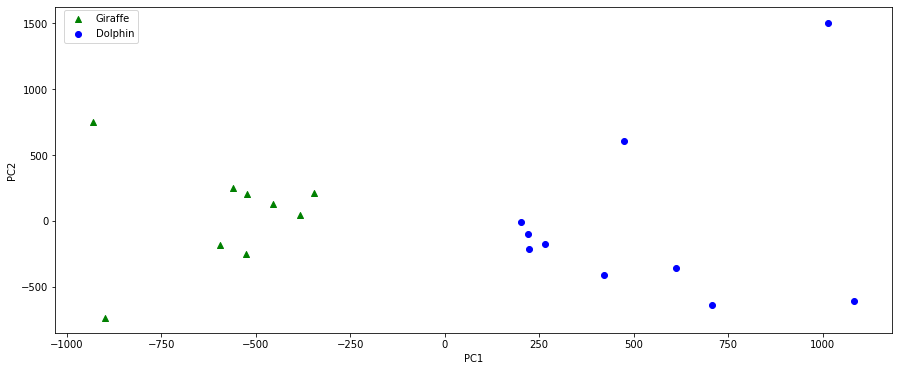

In [52]:
X_r = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(15, 6))
plt.scatter(X_r[y=='Giraffe',0], X_r[y=='Giraffe', 1], marker='^', c='g', label='Giraffe')
plt.scatter(X_r[y=='Dolphin',0], X_r[y=='Dolphin', 1], marker='o', c='b', label='Dolphin')
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


<h2 id="Model4">Model4:  Perform Transfer Learning with ImageNet ResNet50 Model<a name="Model4" /><a class="anchor-link" href="#Model4"></a></h2>


Transfer learning is a machine learning method where a model that was developed for one task is reused as the starting point for a model that is developed for a second, different task. This example uses DLPy to import an ImageNet ResNet50 Caffe model with pre-trained weights and saves the network as Model4.

This example requires access to a ResNet50 Caffe library model, including the associated `.h5` file that contains the associated trained model weights. You can obtain the ResNet50 `.caffemodel` and `.caffemodelh5` binaries in a zip format from the SAS Deep Learning Models and Tools support page [here](http://support.sas.com/documentation/prod-p/vdmml/zip/resnet50.zip).

You should unpack and save the binaries from `resnet50.zip` to a directory location that the server can see. This example saves the files to an example server path `disk/linux/dlpy/`. The path in your enviornment will be different.

The example code below begins by naming the .h5 model weights and defining the system path to them. Next, the example  defines a ResNet50 model with the following parameters:

* The input data contains 2 classes (Dolphin and Giraffe).
* The input data consists of BGR color images, so n_channels=3.
* The input image dimensions are 224 px high by 224 px wide.
* Do not flip or crop existing images for augmentation.
* Set BGR offsets for each input channel using the channel mean values that were identified in the training image output. 
* Use pretrained weights as they are defined in the imported .h5 file.
* Do not include fully trained weights in the top (fully connected) layers of the network.

In [53]:
# PRE_TRAIN_WEIGHT_LOC points to the name of the fully-qualified directory that contains your model weights.

PRE_TRAIN_WEIGHT_LOC = '/server-path/to-saved-model/weight-files/'
pre_train_weight_file = os.path.join(PRE_TRAIN_WEIGHT_LOC, 'ResNet-50-model.caffemodel.h5')

model4 = ResNet50_Caffe(sess, model_table='ResNet50_Caffe', 
                n_classes=2, n_channels=3, width=224, height=224, scale=1,
                random_flip='none', random_crop='none',
                offsets=tr_img.channel_means,
                pre_trained_weights=True, 
                pre_trained_weights_file=pre_train_weight_file,
                include_top=False)

NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50_caffe" according to the model name in the table.


Importing this pre-trained model is the "transfer" part of transfer learning. Instead of designing a network from scratch, we import a similar pre-built task-trained model. Now customize this model by performing further training on the model `Model4` using the toy data set `tr_img` used so far. 

The following code uses `tr_img` with a mini-batch size of 1, for 1 epoch, and a learning rate of 0.005.

In [54]:
model4.fit(data=tr_img, 
           mini_batch_size=1,
           max_epochs=1, 
           lr=5E-3,  
           gpu=Gpu(devices=[1]))

NOTE: Inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 23512194.
NOTE:  The approximate memory cost is 738.00 MB.
NOTE:  Loading weights cost       0.13 (s).
NOTE:  Initializing each layer cost       1.37 (s).
NOTE:  The total number of threads on each worker is 56.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 56.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Training)
NOTE:      0    56    0.005           0.9002     0.3929     7.17
NOTE:

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                resnet50_caffe
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                           126
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             1
 5              Number of Convolutional Layers                            53
 6                    Number of Pooling Layers                             2
 7            Number of Fully Connected Layers                             0
 8        Number of Batch Normalization Layers                            53
 9                   Number of Residual Layers                            16
 10                Number of Weight Parameters                      23459008
 11                  Number of Bias Parameters                         53186
 12           Total Number of Model Parameters                      23512194
 13  Approximate Memory Cost for Training (MB)                           770

[OptIterHistory]

    Epoch  LearningRate      Loss  FitError
 0      1         0.005  0.451442  0.160714

[OutputCasTables]

             casLib                    Name      Rows  Columns  \
 0  CASUSER(chrobi)  resnet50_caffe_weights  23565314        3   
 
                                             casTable  
 0  CASTable('resnet50_caffe_weights', caslib='CAS...  

+ Elapsed: 11.4s, user: 36.3s, sys: 2.62s, mem: 886mb

### Model4: Score Test Data

Now use the trained model `Model4` to score new input data.

In [55]:
model4.evaluate(data=te_img, gpu=Gpu(devices=[0]), buffer_size=1)

NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            19
 1  Number of Observations Used            19
 2  Misclassification Error (%)             0
 3                   Loss Error      0.232784

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(chrobi)  Valid_Res_O5DceH    19        9   
 
                                             casTable  
 0  CASTable('Valid_Res_O5DceH', caslib='CASUSER(c...  

+ Elapsed: 4.92s, user: 5.36s, sys: 1.11s, mem: 782mb

The trained model4 performs very well when scoring the test data. 100% (19 of 19) of the images in the test data were correctly classified. (*Note:* using the toy data set in other training environments might produce results might that vary slightly (+/-1). This is normal.)

The following code generates a confusion matrix that illustrates the classification prediction accuracy. 

In [56]:
model4.valid_conf_mat

[Crosstab]

    _label_  Col1  Col2
 0  Dolphin  10.0   0.0
 1  Giraffe   0.0   9.0

+ Elapsed: 0.00658s, sys: 0.025s, mem: 2.51mb

You can see that 10 dolphin images and 9 giraffe images were correctly classified, for a total of 19
correctly classified images.  The confusion matrix also shows that there were no misclassifications 
when scoring the test images. (*Note:* with the toy data set, different training environments might return slightly different (+/- 1) classification results; this is normal.)  


The next step visualizes some of the image predictions from the test data. The function 
`plot_evaluate_res()` creates bar charts of 2 random individual classification predictions. Setting 
`img_type='A'` in the following code means that all classifications (either correct or incorrect) are eligible 
for plotting. In this example, all of predictions are correct.


NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(chrobi).


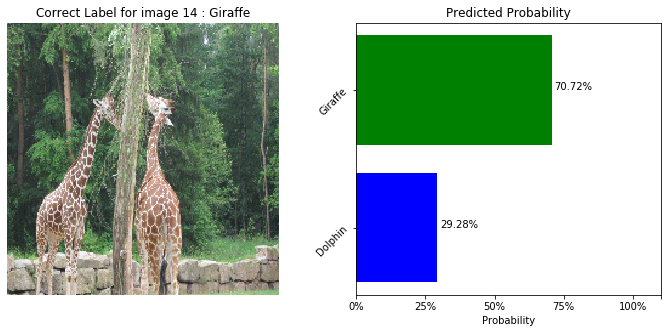

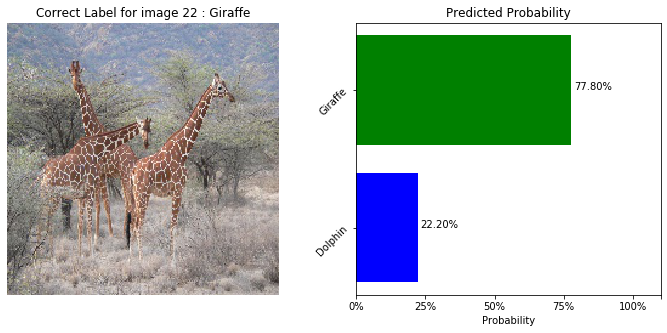

In [57]:
model4.plot_evaluate_res(img_type='A', randomize=True, n_images=2)

### Model4: Perform Heatmap Analysis

Heat maps are visualization tools that use color to indicate different values of interest. In this case, the most important regions of an image are the regions that provide the most useful information to the model, enabling it to determine a distinction of the actual class. In other words, heat maps visualize which parts of an image are most useful to the model when predicting the class.

The following code to generate heat maps uses the score results from the CNN network model1. The analysis focuses on a 56 x 56 pixel mask over the image using a step size of 8 pixels. The 'max display' setting in the code limits the heat map output to two rows, where each row displays the heat map information for a random image.

Using results from model.predict()
NOTE: The number of images in the table is too large, only 2 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_SHQJKX contains compressed images.


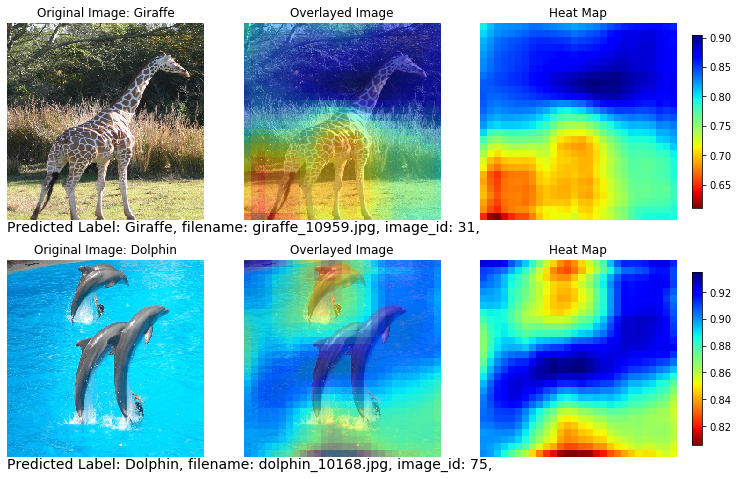

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_SHQjKx from caslib CASUSER(chrobi).


_id_        _filename_0                                            _image_  \
0   31  giraffe_10959.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1   75  dolphin_10168.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

   _label_ I__label_                                           heat_map  \
0  Giraffe   Giraffe  [[0.797755777835846, 0.797755777835846, 0.7977...   
1  Dolphin   Dolphin  [[0.9236295819282532, 0.9236295819282532, 0.92...   

   P__label_Dolphin  P__label_Giraffe  
0          0.165403          0.834597  
1          0.904712          0.095288

In [58]:
model4.heat_map_analysis( mask_width=56, mask_height=56, step_size=8, max_display=2)


<h2 id="Model5">Model5: Load A Pre-Trained VGG16 Model From .sashdat Table File <a name="Model5" /><a class="anchor-link" href="#Model5"></a></h2> 

It is useful to save models in the `.sashdat` (SAS Hadoop Data Table) format in order to faciliate reloading the models for later access. For example, you might want to retrain the model later with updated data, or use the model for transfer learning.

During the Model3 example, after importing a pre-trained Caffe VGG-16 network, the network was saved for portable re-use in the form of a .sashdat file. Now use the saved `vgg16.sashdat` file from Model3 to create Model5. 

In [60]:
model5 = Model(sess)

# The model_file variable holds the fully-qualified server-side path 
# and file name for your deployed .sashdat model. This should be the 
# server location where you deployed the 'model3' vgg16.sashdat table.

model_file = '/path-to/server-accessible/deployment-directory/your-saved-model-file.sashdat'


# Load the .sashdat file for the stored model.
model5.load(path=model_file)

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "vgg16" according to the model name in the table.
NOTE: vgg16_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: vgg16_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


## Model5: Score Test Images

After importing the pre-trained VGG16 model with weights as `model5`, evaluate the effectiveness of the imported model by using it to score the dolphin and giraffe test images:

In [61]:
model5.evaluate(te_img)

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            19
 1  Number of Observations Used            19
 2  Misclassification Error (%)           100
 3                   Loss Error             0

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(chrobi)  Valid_Res_wUSYyg    19     1007   
 
                                             casTable  
 0  CASTable('Valid_Res_wUSYyg', caslib='CASUSER(c...  

+ Elapsed: 13.6s, user: 38.9s, sys: 7.28s, mem: 1.07e+04mb

The imported model performs well. 19 of 19 images in the test data set were correctly classified. (*Note:* In other training environments, the results might vary slightly with the toy data set. Small variations in the output results are normal.)

We can view the distribution of the correctly classified images with a confusion matrix. In this example, the matrix is a two-row cross-tabulation chart for Dolphin and Giraffe. Row 0 values reflect the number of predicted Dolphin images, and row 1 values reflect the number of predicted Giraffe images. 

In [62]:
model5.valid_conf_mat

[Crosstab]

    _label_  Col1  Col2  Col3  Col4  Col5  Col6  Col7  Col8  Col9  Col10  \
 0  Dolphin   0.0   1.0   0.0   1.0   0.0   0.0   3.0   3.0   0.0    0.0   
 1  Giraffe   1.0   0.0   1.0   0.0   3.0   1.0   0.0   0.0   1.0    1.0   
 
    Col11  Col12  Col13  
 0    1.0    1.0    0.0  
 1    0.0    0.0    1.0  

+ Elapsed: 0.00835s, user: 0.0113s, sys: 0.00632s, mem: 3.77mb

Of the 100% correctly classified images, 10 were of dolphins, and 9 were giraffes.  (Note: In other training environments, the results might vary slightly with the toy data set. Small variations in the output results are normal.)